## マイク補正なしの測位

マイクを真っ直ぐに向けての測位
20 点、補正なし
4k-13kHz,インターバル 0.2s


In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_spectrum_amplitude
from positioning.sound_db import SoundDB

In [3]:
db = SoundDB("../data/reference_2d", interval=0.2, dim=2)

In [4]:
true_pos = pd.read_csv("../data/pos2d_20230807/true_positions.csv", index_col=0)

In [5]:
true_pos.head()

,x,y
test0,-0.6,0.9
test1,-0.6,1.2
test2,-0.6,1.5
test3,-0.6,1.8
test4,-0.3,0.9


In [6]:
est_poses = []
errors = []
for i in range(20):
    test_signal = readwav(f"../data/pos2d_20230807/test{i}.wav")
    err = []
    pos = []
    for j in range(100):
        est_pos = np.ravel(db.positioning(test_signal[j * 96000 : (j + 2) * 96000]))
        pos.append(est_pos)
        err.append(np.linalg.norm(est_pos - true_pos.iloc[i]))
    est_poses.append(pos)
    errors.append(err)

In [7]:
df_est = pd.DataFrame()
for i in range(20):
    df_est_pos = pd.DataFrame(est_poses[i], columns=["x", "y"])
    df_est_pos["error"] = errors[i]
    df_est_pos["test_position"] = f"test{i}"
    df_est = pd.concat([df_est, df_est_pos])

In [8]:
df_est.reset_index(inplace=True, drop=True)

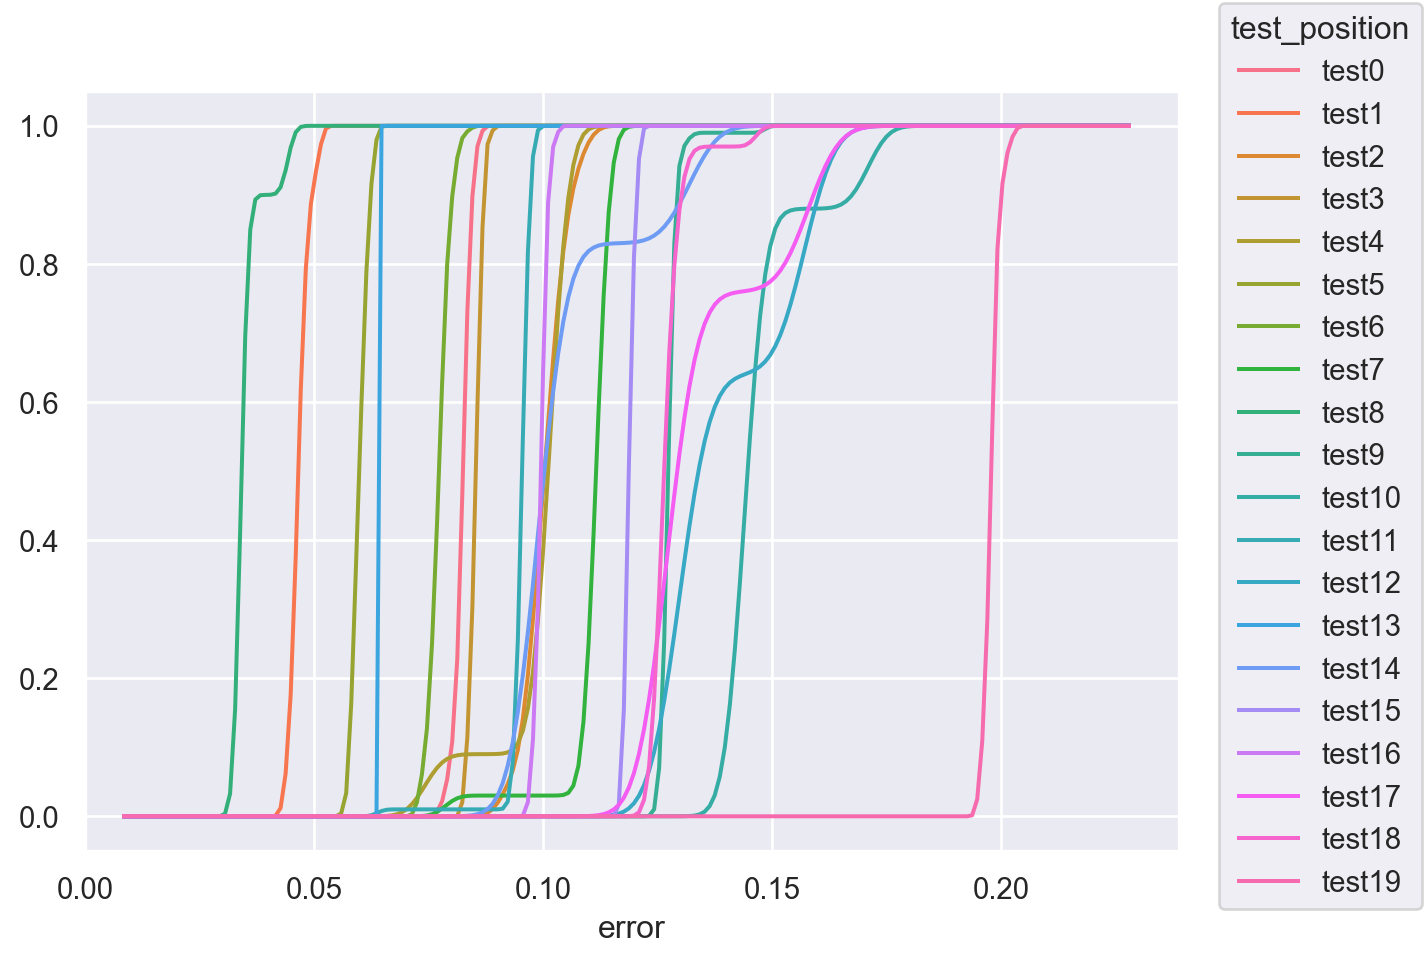

In [9]:
(
    so.Plot(df_est, x="error", color="test_position")
    .add(so.Lines(), so.KDE(cumulative=True, common_norm=False))
    .limit(x=(0, None))
)

In [10]:
df_positions = df_est[["x", "y", "test_position"]]
df_positions.loc[:, "true_or_test"] = "test"
true_pos["test_position"] = true_pos.index
true_pos["true_or_test"] = "true"
df_positions = pd.concat([df_positions, true_pos])
df_positions.reset_index(drop=True, inplace=True)
df_positions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              2020 non-null   float64
 1   y              2020 non-null   float64
 2   test_position  2020 non-null   object 
 3   true_or_test   2020 non-null   object 
dtypes: float64(2), object(2)
memory usage: 63.3+ KB


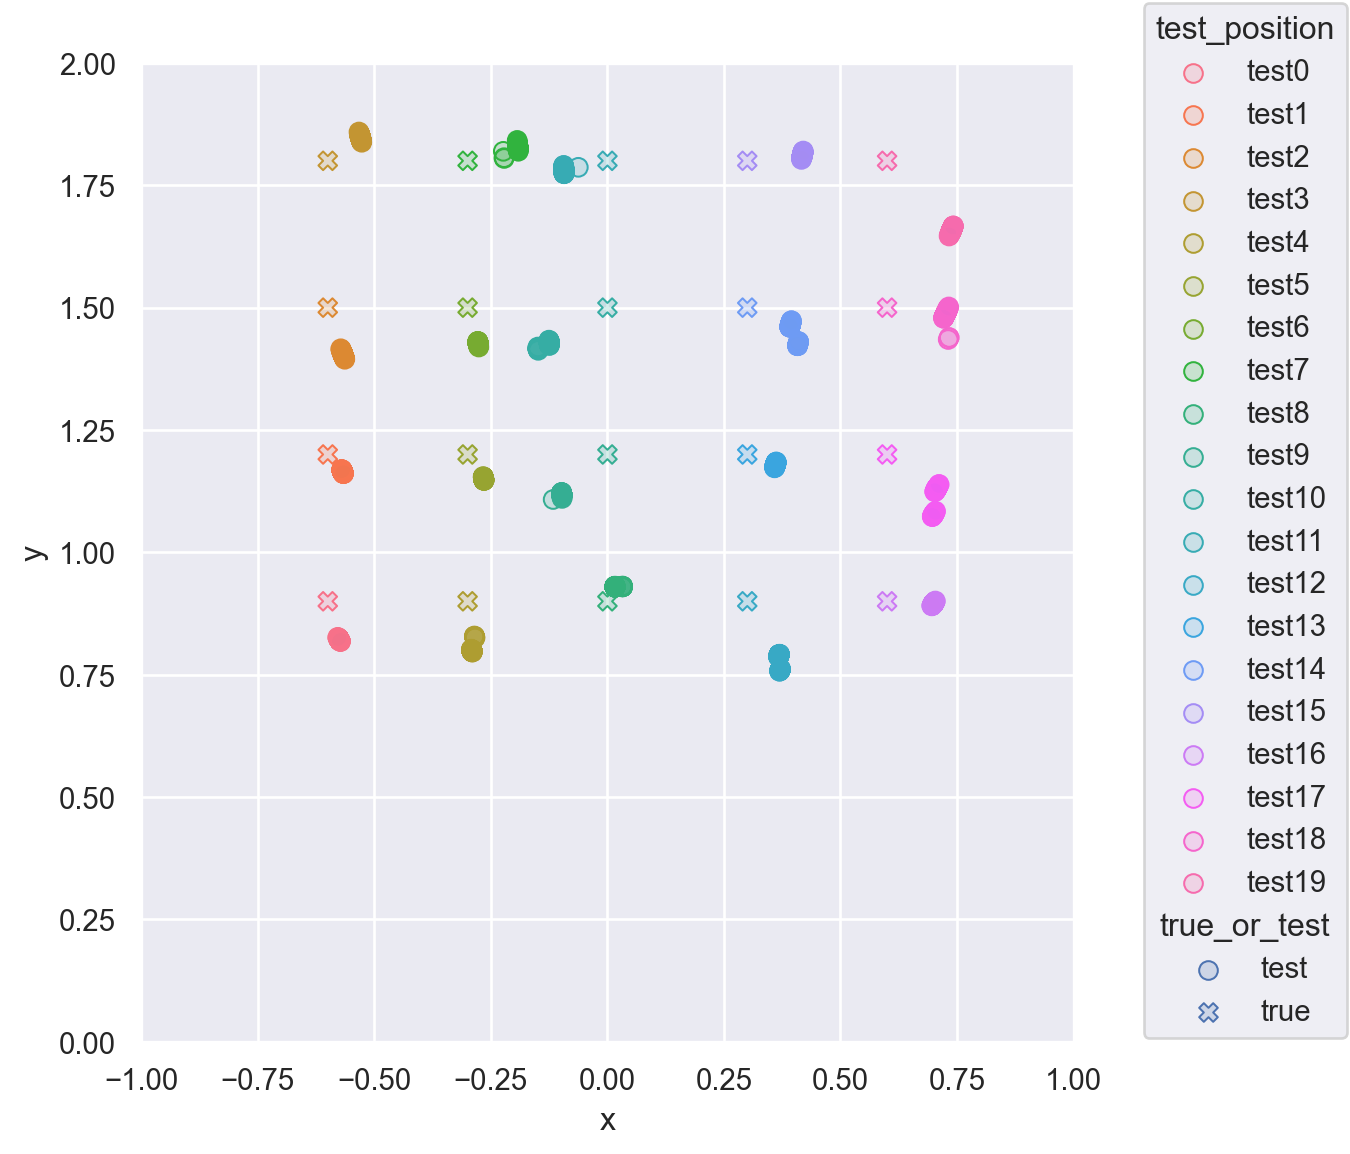

In [11]:
(
    so.Plot(df_positions, x="x", y="y", color="test_position", marker="true_or_test")
    .add(so.Dots(pointsize=7))
    .limit(x=(-1, 1), y=(0, 2))
    .layout(size=(6, 6))
)

Usonic にて  
マイクの角度特性を見るなら単純にゆっくりのチャープで見たほうがいい
遅延特性を考慮すれば距離がわかる


In [12]:
fiftyth_p = []
ninetyth_p = []
test_points = df_est["test_position"].unique()
for p in test_points:
    fiftyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 50))
    ninetyth_p.append(np.percentile(df_est[df_est["test_position"] == p]["error"], 90))
df_cdf = pd.DataFrame(
    {"test_position": test_points, "50th": fiftyth_p, "90th": ninetyth_p}
)
df_cdf.head(20)

,test_position,50th,90th
0,test0,0.082466,0.084296
1,test1,0.046423,0.049270
2,test2,0.100344,0.105822
3,test3,0.085281,0.086942
4,test4,0.101323,0.102785
5,test5,0.059799,0.062115
6,test6,0.077385,0.079883
7,test7,0.111580,0.112328
8,test8,0.033982,0.035877
9,test9,0.127342,0.128424
